- Data Augmentation Xception model (~0.7889): https://www.kaggle.com/faizunnabi/data-augmentation-xception-model-0-7889/code
- data_path: M:\dataset\Whale_Identification
- 思路：图像resize()到256*256大小，然后使用预训练的Xception模型，提取深度特征，然后构建一个小FC网络，映射到类别

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # 数据可视化
import cv2
from keras.models import Sequential
from keras.layers import  Dense,Dropout
from keras.applications.xception import Xception
from keras.preprocessing.image import  ImageDataGenerator,img_to_array
from keras.applications.xception import preprocess_input
from sklearn.preprocessing import  LabelEncoder,OneHotEncoder
from keras.callbacks import  ReduceLROnPlateau

import datetime as dt

%matplotlib inline

Using TensorFlow backend.


In [2]:
data_path= "M:/dataset/Whale_Identification/train.csv"

whale_labels=pd.read_csv(data_path)

In [3]:
whale_labels.head()#.shape

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [4]:
top_populars=whale_labels.groupby("Id").count().sort_values(by="Image",ascending=False).reset_index().head(10)
print(top_populars)

          Id  Image
0  new_whale    810
1  w_1287fbc     34
2  w_98baff9     27
3  w_7554f44     26
4  w_1eafe46     23
5  w_fd1cb9d     22
6  w_ab4cae2     22
7  w_693c9ee     22
8  w_987a36f     21
9  w_43be268     21


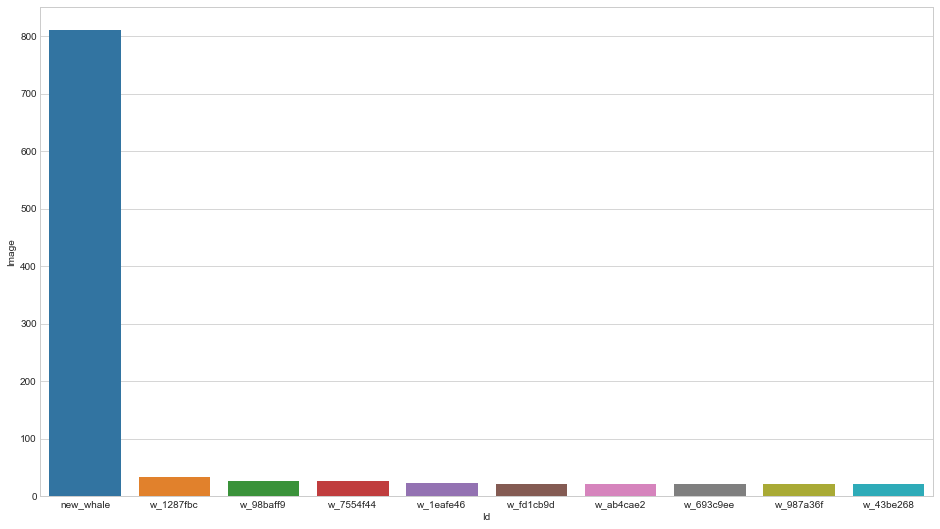

In [5]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,9))
sns.barplot(x="Id",y="Image",data=top_populars)

In [6]:
top_populars.describe()

,Image
count,10.000000
mean,102.800000
std,248.516845
min,21.000000
25%,22.000000
50%,22.500000
75%,26.750000
max,810.000000


In [7]:
top_populars=whale_labels.groupby("Id").count().sort_values(by="Image",ascending=False).reset_index()
#print(top_populars)
print(top_populars.describe())
top_categories = list(top_populars['Id'].values)
#top_categories
#len(top_categories) # 4251

             Image
count  4251.000000
mean      2.317102
std      12.586066
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max     810.000000


In [8]:
df = whale_labels[whale_labels["Id"].isin(top_categories)]
df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
7,0031c258.jpg,new_whale
8,0035632e.jpg,w_3d0bc7a
9,0037e7d3.jpg,w_50db782


In [9]:
cn = df.groupby('Id').count().reset_index()
cn

,Id,Image
0,new_whale,810
1,w_0013924,3
2,w_001ebbc,1
3,w_002222a,2
4,w_002b682,1
5,w_002dc11,1
6,w_0087fdd,2
7,w_008c602,1
8,w_009dc00,2
9,w_00b621b,2


In [10]:
TRIAN_NUM=9850
CLASS_NUM=4251

width = 150
height = 150
channels = 3
batch_size = 16

base_model = Xception(include_top=False,input_shape=(width,height,3))

In [12]:
# base_model.summary()

In [13]:
datagene=ImageDataGenerator(rotation_range=20,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           zoom_range=0.2,
                           rescale=1./255,
                           horizontal_flip=True)

In [14]:
lbe=LabelEncoder()

y1=df["Id"].values

print(y1)
yl = lbe.fit_transform(y1)
print(y1)
onhe=OneHotEncoder()

yl = onhe.fit_transform(yl.reshape(-1,1))
print(y1)

['w_e15442c' 'w_1287fbc' 'w_da2efe0' ..., 'w_8b56cb1' 'w_2dcbf82'
 'w_b9bfd4e']
['w_e15442c' 'w_1287fbc' 'w_da2efe0' ..., 'w_8b56cb1' 'w_2dcbf82'
 'w_b9bfd4e']
['w_e15442c' 'w_1287fbc' 'w_da2efe0' ..., 'w_8b56cb1' 'w_2dcbf82'
 'w_b9bfd4e']


In [34]:
# df

- 怎么取一部分1028的样本，并且取出对应的label,然后再将label取前面10个

In [24]:
root= "M:/dataset/Whale_Identification/train/"

img_array = np.zeros(shape=(TRIAN_NUM,width,width,3)) #1028
label_array = yl.toarray()
i=0
for index,row in df.iterrows():
    if index<10:
        print(index,row,root+row["Image"])
    img = cv2.imread(root+row["Image"],0)
    img = cv2.resize(img,(150,150))
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img = img_to_array(img)
    img_array[i] = img

0 Image    00022e1a.jpg
Id          w_e15442c
Name: 0, dtype: object M:/dataset/Whale_Identification/train/00022e1a.jpg
1 Image    000466c4.jpg
Id          w_1287fbc
Name: 1, dtype: object M:/dataset/Whale_Identification/train/000466c4.jpg
2 Image    00087b01.jpg
Id          w_da2efe0
Name: 2, dtype: object M:/dataset/Whale_Identification/train/00087b01.jpg
3 Image    001296d5.jpg
Id          w_19e5482
Name: 3, dtype: object M:/dataset/Whale_Identification/train/001296d5.jpg
4 Image    0014cfdf.jpg
Id          w_f22f3e3
Name: 4, dtype: object M:/dataset/Whale_Identification/train/0014cfdf.jpg
5 Image    0025e8c2.jpg
Id          w_8b1ca89
Name: 5, dtype: object M:/dataset/Whale_Identification/train/0025e8c2.jpg
6 Image    0026a8ab.jpg
Id          w_eaad6a8
Name: 6, dtype: object M:/dataset/Whale_Identification/train/0026a8ab.jpg
7 Image    0031c258.jpg
Id          new_whale
Name: 7, dtype: object M:/dataset/Whale_Identification/train/0031c258.jpg
8 Image    0035632e.jpg
Id          w_3d

In [25]:
print(img_array.shape)
#img_array

print(label_array.shape)
# print(label_array)


(9850, 150, 150, 3)
(9850, 4251)


In [45]:
sub_label=label_array[:,:10]

train_f = datagene.flow(img_array,sub_label,batch_size=batch_size)
print(img_array.shape,sub_label.shape)

(9850, 150, 150, 3) (9850, 10)


In [46]:
def extract_features(sample_count, datagen):
    start = dt.datetime.now()
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count,10))
    generator = datagen
    i = 0
    for inputs_batch,labels_batch in generator:
        print(inputs_batch.shape,labels_batch.shape)
        stop = dt.datetime.now()
        time = (stop - start).seconds
        print('\r',
        'Extracting features from batch', str(i+1), '/', #len(datagen),
        '-- run time:', time,'seconds',
        end='')
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if (i+1) * batch_size >= sample_count:
            break
    print("\n")
    return features,labels

In [47]:

train_features, train_labels = extract_features(1028, train_f)


(16, 150, 150, 3) (16, 10)
 Extracting features from batch 1 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 2 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 3 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 4 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 5 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 6 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 7 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 8 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 9 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 10 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 11 / -- run time: 0 seconds(16, 150, 150, 3) (16, 10)
 Extracting features from batch 12 /

In [48]:
flat_dim = 5 * 5 * 2048

print(train_features.shape, train_labels.shape)
train_features = np.reshape(train_features, (1028, flat_dim))

(1028, 5, 5, 2048) (1028, 10)


In [49]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [50]:
model = Sequential()

model.add(Dense(512, activation='relu', input_dim=flat_dim))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 26,220,042
Trainable params: 26,220,042
Non-trainable params: 0
_________________________________________________________________


In [52]:
print(train_features.shape,train_labels.shape)
history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=callbacks)

(1028, 51200) (1028, 10)
Epoch 1/30
1028/1028 [==============================] - 2s - loss: 0.0516 - acc: 0.9835     
Epoch 2/30
1028/1028 [==============================] - 1s - loss: 0.0085 - acc: 0.9990     
Epoch 3/30
1028/1028 [==============================] - 1s - loss: 0.0090 - acc: 0.9990     
Epoch 4/30
1028/1028 [==============================] - 1s - loss: 0.0076 - acc: 0.9990     
Epoch 5/30
1028/1028 [==============================] - 1s - loss: 0.0062 - acc: 0.9990     
Epoch 6/30
1028/1028 [==============================] - 1s - loss: 0.0056 - acc: 0.9990     
Epoch 7/30
1028/1028 [==============================] - 1s - loss: 0.0056 - acc: 0.9990     
Epoch 8/30
1028/1028 [==============================] - 1s - loss: 0.0063 - acc: 0.9990     
Epoch 9/30
1008/1028 [============================>.] - ETA: 0s - loss: 3.6991e-04 - acc: 1.0000
Epoch 00008: reducing learning rate to 0.00010000000474974513.
1028/1028 [==============================] - 1s - loss: 0.0065 - acc: 0

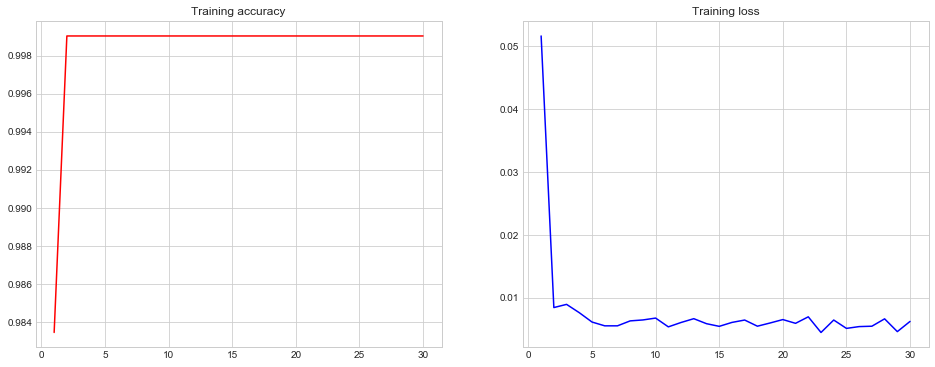

In [53]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
ax1.set_title('Training accuracy')
ax1.plot(epochs, acc, 'red', label='Training acc')
ax2.set_title('Training loss')
ax2.plot(epochs, loss, 'blue', label='Training loss')
plt.show()

### test

- 保存模型，得到在test: 15610上的结果，提交查看成绩


In [4]:
# 简单来说 LabelEncoder 是对不连续的数字或者文本进行编号
# sklearn.preprocessing.LabelEncoder()：标准化标签，将标签值统一转换成range(标签值个数-1)范围内
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit([1,5,67,100])
le.transform([1,1,100,67,5])

array([0, 0, 3, 2, 1], dtype=int64)

In [8]:
#OneHotEncoder 用于将表示分类的数据扩维：

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit([[1],[2],[3],[4]])
ohe.transform([[2],[3],[1],[4]]).toarray()

array([[ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.]])